# Retail & Marketing Analytics Project
# Notebook 02: Data Cleaning & Preprocessing
# ------------------------------------------------
# Objective:
# Prepare high-quality, analysis-ready data by handling missing values,
# duplicates, data types, and basic feature consistency.
# This notebook ensures downstream EDA, segmentation, and modeling reliability.


In [2]:
# ============================================================================
# 1. IMPORT LIBRARIES AND LOAD DATA
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Load the raw data
df_sales = pd.read_csv("../data/raw/retail_sales_data.csv")

print("=" * 80)
print("DATA CLEANING AND PREPROCESSING")
print("=" * 80)
print(f"\nInitial Dataset Shape: {df_sales.shape}")
print(f"Initial Memory Usage: {df_sales.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Create a copy for cleaning
df_clean = df_sales.copy()


DATA CLEANING AND PREPROCESSING

Initial Dataset Shape: (10000, 19)
Initial Memory Usage: 8.23 MB


In [3]:
# ============================================================================
# 2. HANDLE MISSING VALUES
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: HANDLING MISSING VALUES")
print("=" * 80)

# Check missing values
print("\nMissing Values Before Treatment:")
missing_before = df_clean.isnull().sum()
missing_before_pct = (missing_before / len(df_clean) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_before.index,
    'Missing_Count': missing_before.values,
    'Missing_Percentage': missing_before_pct.values
})

missing_df = (
    missing_df[missing_df['Missing_Count'] > 0]
    .sort_values('Missing_Count', ascending=False)
)

print(missing_df)

# Separate columns by type
numerical_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print("\nTreatment Strategy:")

# Handle numerical missing values (median)
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median_value = df_clean[col].median()
        df_clean[col].fillna(median_value, inplace=True)
        print(f"  {col}: filled with median ({median_value:.2f})")

# Handle categorical missing values (mode / 'Unknown')
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].mode().empty:
            df_clean[col].fillna('Unknown', inplace=True)
            print(f"  {col}: filled with 'Unknown'")
        else:
            mode_value = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_value, inplace=True)
            print(f"  {col}: filled with mode ('{mode_value}')")

print(f"\nMissing values after treatment: {df_clean.isnull().sum().sum()}")



STEP 1: HANDLING MISSING VALUES

Missing Values Before Treatment:
           Column  Missing_Count  Missing_Percentage
4   Customer_Name             50                 0.5
14         Profit             30                 0.3

Treatment Strategy:
  Profit: filled with median (20.33)
  Customer_Name: filled with mode ('Customer_133')

Missing values after treatment: 0


In [4]:
# ============================================================================
# 3. REMOVE DUPLICATES
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: REMOVING DUPLICATES")
print("=" * 80)

# Check duplicates
duplicates_before = df_clean.duplicated().sum()
print(f"\nDuplicate rows found: {duplicates_before}")

# Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"Duplicates removed: {duplicates_before}")
print(f"New dataset shape: {df_clean.shape}")

# Reset index after removing duplicates
df_clean.reset_index(drop=True, inplace=True)



STEP 2: REMOVING DUPLICATES

Duplicate rows found: 0
Duplicates removed: 0
New dataset shape: (10000, 19)


In [5]:
# ============================================================================
# 4. DATA TYPE CONVERSION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: DATA TYPE CONVERSION")
print("=" * 80)

# Convert date columns to datetime
date_columns = ['Order_Date', 'Ship_Date']
for col in date_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"Converted {col} to datetime")

# Convert categorical columns to category dtype
categorical_columns = [
    'Segment',
    'Region',
    'Product_Category',
    'Product_Sub_Category',
    'Order_Priority'
]

for col in categorical_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype('category')
        print(f"Converted {col} to category")

# Ensure correct numerical dtypes
if 'Quantity' in df_clean.columns:
    df_clean['Quantity'] = df_clean['Quantity'].astype('int32')

print("\nData types optimized")
print(f"Memory usage after optimization: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



STEP 3: DATA TYPE CONVERSION
Converted Order_Date to datetime
Converted Ship_Date to datetime
Converted Segment to category
Converted Region to category
Converted Product_Category to category
Converted Product_Sub_Category to category
Converted Order_Priority to category

Data types optimized
Memory usage after optimization: 3.88 MB



STEP 4: OUTLIER DETECTION AND TREATMENT

Outlier Analysis:

Sales
Outliers detected: 328 (3.28%)
Lower bound: -71.87
Upper bound: 275.33

Quantity
Outliers detected: 0 (0.00%)
Lower bound: -3.00
Upper bound: 13.00

Profit
Outliers detected: 87 (0.87%)
Lower bound: -61.87
Upper bound: 101.47


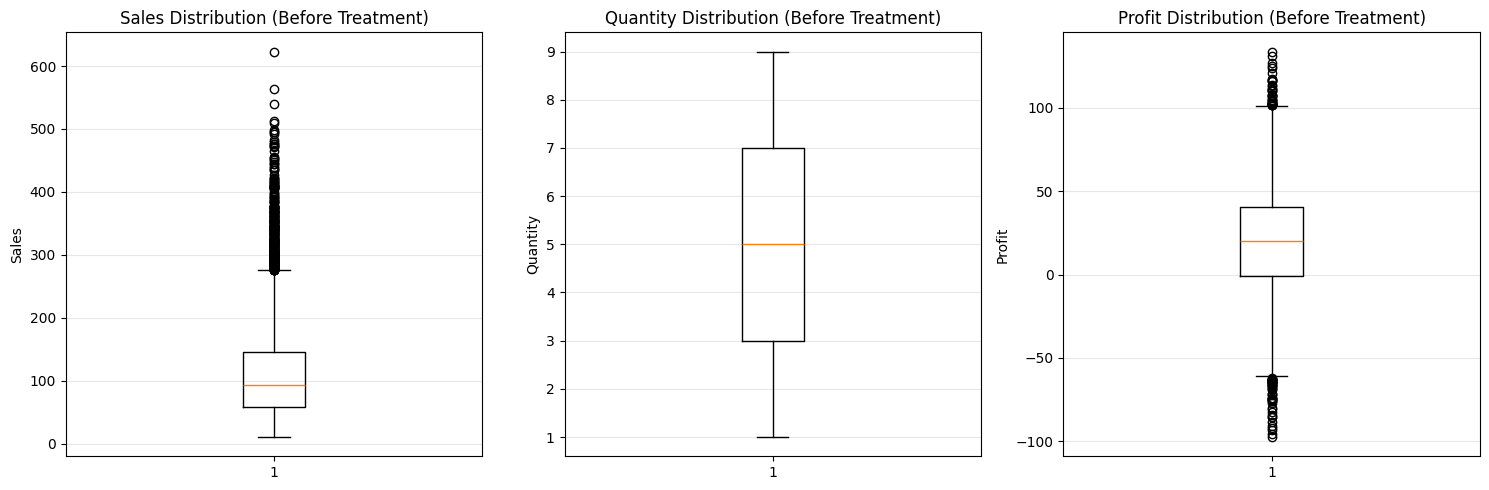


Outlier Treatment (Capping):
Sales: capped to range [-71.87, 275.33]
Profit: capped to range [-61.87, 101.47]


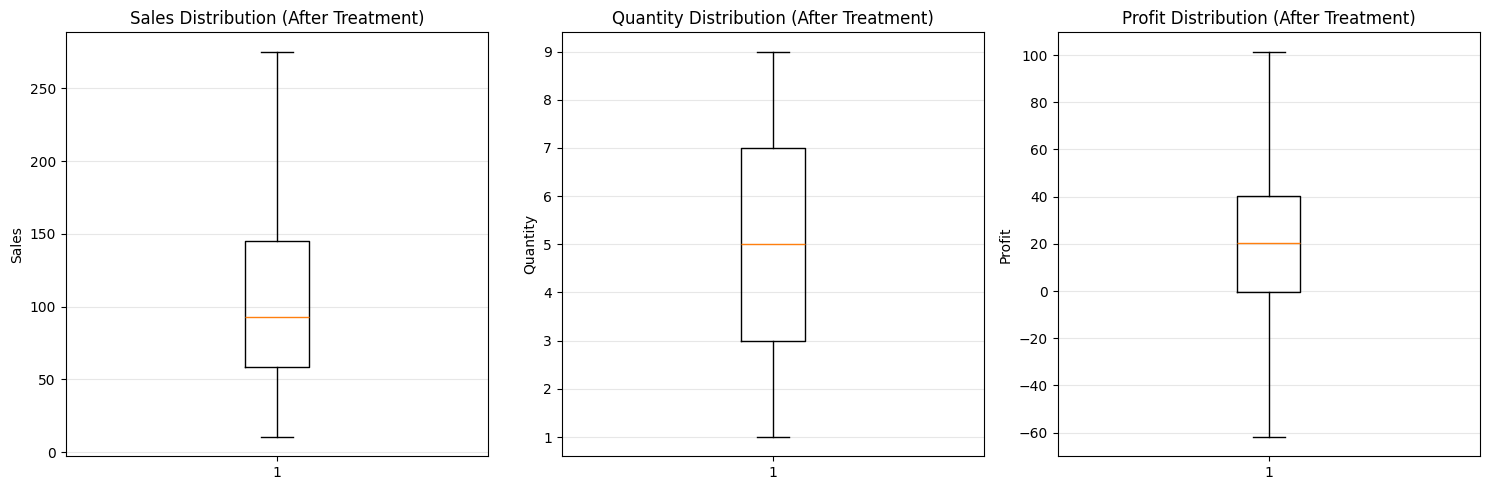

In [6]:
# ============================================================================
# 5. OUTLIER DETECTION AND TREATMENT
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: OUTLIER DETECTION AND TREATMENT")
print("=" * 80)

def detect_outliers_iqr(data, column):
    """
    Detect outliers using the IQR method.
    Returns outlier dataframe, lower bound, upper bound.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


# Columns to check for outliers
outlier_columns = ['Sales', 'Quantity']
if 'Profit' in df_clean.columns:
    outlier_columns.append('Profit')

print("\nOutlier Analysis:")
outlier_summary = []

for col in outlier_columns:
    if col in df_clean.columns:
        outliers, lb, ub = detect_outliers_iqr(df_clean, col)
        outlier_pct = (len(outliers) / len(df_clean)) * 100

        outlier_summary.append({
            'Column': col,
            'Outliers': len(outliers),
            'Percentage': f"{outlier_pct:.2f}%",
            'Lower_Bound': f"{lb:.2f}",
            'Upper_Bound': f"{ub:.2f}"
        })

        print(f"\n{col}")
        print(f"Outliers detected: {len(outliers)} ({outlier_pct:.2f}%)")
        print(f"Lower bound: {lb:.2f}")
        print(f"Upper bound: {ub:.2f}")

# Ensure figures directory exists
import os
os.makedirs("figures", exist_ok=True)

# Visualize outliers before treatment
fig, axes = plt.subplots(1, len(outlier_columns), figsize=(15, 5))
if len(outlier_columns) == 1:
    axes = [axes]

for idx, col in enumerate(outlier_columns):
    axes[idx].boxplot(df_clean[col].dropna())
    axes[idx].set_title(f"{col} Distribution (Before Treatment)")
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("figures/03_outliers_before_treatment.png", dpi=300, bbox_inches="tight")
plt.show()

# Outlier treatment using capping (Winsorization)
print("\nOutlier Treatment (Capping):")
for col in outlier_columns:
    outliers, lb, ub = detect_outliers_iqr(df_clean, col)
    if len(outliers) > 0:
        df_clean[f"{col}_Original"] = df_clean[col]
        df_clean[col] = df_clean[col].clip(lower=lb, upper=ub)
        print(f"{col}: capped to range [{lb:.2f}, {ub:.2f}]")

# Visualize after treatment
fig, axes = plt.subplots(1, len(outlier_columns), figsize=(15, 5))
if len(outlier_columns) == 1:
    axes = [axes]

for idx, col in enumerate(outlier_columns):
    axes[idx].boxplot(df_clean[col].dropna())
    axes[idx].set_title(f"{col} Distribution (After Treatment)")
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("figures/04_outliers_after_treatment.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# ============================================================================
# 6. DATA VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: DATA VALIDATION")
print("=" * 80)

print("\nChecking for invalid values")

# Validation checks
if 'Sales' in df_clean.columns:
    negative_sales = (df_clean['Sales'] < 0).sum()
    print(f"Negative Sales values: {negative_sales}")

if 'Quantity' in df_clean.columns:
    invalid_quantity = (df_clean['Quantity'] <= 0).sum()
    print(f"Zero or Negative Quantity values: {invalid_quantity}")

if 'Discount' in df_clean.columns:
    invalid_discount = ((df_clean['Discount'] < 0) | (df_clean['Discount'] > 1)).sum()
    print(f"Invalid Discount values: {invalid_discount}")

# Date consistency check
if {'Order_Date', 'Ship_Date'}.issubset(df_clean.columns):
    invalid_dates = (df_clean['Ship_Date'] < df_clean['Order_Date']).sum()
    print(f"Ship Date before Order Date: {invalid_dates}")

print("\nValidation completed")


In [7]:
# ============================================================================
# 7. SUMMARY STATISTICS AFTER CLEANING
# ============================================================================

print("\n" + "=" * 80)
print("CLEANED DATA SUMMARY")
print("=" * 80)

print(f"\nFinal Dataset Shape: {df_clean.shape}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nData Quality Metrics")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicate rows: {df_clean.duplicated().sum()}")
print(
    f"Complete rows: {df_clean.dropna().shape[0]:,} "
    f"({(df_clean.dropna().shape[0] / len(df_clean) * 100):.2f}%)"
)

print("\nKey Statistics")
if 'Sales' in df_clean.columns:
    print(f"Total Sales: {df_clean['Sales'].sum():,.2f}")
    print(f"Average Order Value: {df_clean['Sales'].mean():,.2f}")

if 'Customer_ID' in df_clean.columns:
    print(f"Unique Customers: {df_clean['Customer_ID'].nunique():,}")

if 'Product_ID' in df_clean.columns:
    print(f"Unique Products: {df_clean['Product_ID'].nunique():,}")




CLEANED DATA SUMMARY

Final Dataset Shape: (10000, 21)
Memory usage: 4.03 MB

Data Quality Metrics
Missing values: 0
Duplicate rows: 0
Complete rows: 10,000 (100.00%)

Key Statistics
Total Sales: 1,078,670.98
Average Order Value: 107.87
Unique Customers: 1,986
Unique Products: 499


In [8]:
# ============================================================================
# 9. SAVE CLEANED DATA AND REPORTS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 7: SAVING CLEANED DATA")
print("=" * 80)

import os

# Ensure required directories exist
os.makedirs("data/processed", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# Save cleaned dataset
output_path = "data/processed/cleaned_retail_sales.csv"
df_clean.to_csv(output_path, index=False)
print(f"Cleaned data saved: {output_path}")

# Save data dictionary
data_dict = pd.DataFrame({
    "Column_Name": df_clean.columns,
    "Data_Type": df_clean.dtypes.values,
    "Non_Null_Count": df_clean.count().values,
    "Null_Count": df_clean.isnull().sum().values,
    "Unique_Values": [df_clean[col].nunique() for col in df_clean.columns],
    "Sample_Value": [
        df_clean[col].iloc[0] if len(df_clean) > 0 else None
        for col in df_clean.columns
    ]
})

dict_path = "reports/data_dictionary.csv"
data_dict.to_csv(dict_path, index=False)
print(f"Data dictionary saved: {dict_path}")

# Create cleaning summary report (CLEANING ONLY)
cleaning_report = f"""
DATA CLEANING AND PREPROCESSING REPORT
{'=' * 80}

DATASET STATUS AFTER CLEANING
- Records: {df_clean.shape[0]:,}
- Features: {df_clean.shape[1]}
- Missing Values: {df_clean.isnull().sum().sum()}
- Duplicate Rows: {df_clean.duplicated().sum()}
- Memory Usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB

DATA CLEANING OPERATIONS PERFORMED
- Missing value treatment (median / mode strategy)
- Duplicate removal
- Data type standardization
- Outlier detection and capping (IQR method)
- Data validation checks

NEXT STEPS
- Proceed to Exploratory Data Analysis (Notebook 03)

Report Generated On:
{pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'=' * 80}
"""

report_path = "reports/02_cleaning_report.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(cleaning_report)

print(f"Cleaning report saved: {report_path}")

print("\n" + "=" * 80)
print("NOTEBOOK 02 COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nNext Step: Open Notebook 03 - Exploratory Data Analysis")
print("=" * 80)



STEP 7: SAVING CLEANED DATA
Cleaned data saved: data/processed/cleaned_retail_sales.csv
Data dictionary saved: reports/data_dictionary.csv
Cleaning report saved: reports/02_cleaning_report.txt

NOTEBOOK 02 COMPLETED SUCCESSFULLY

Next Step: Open Notebook 03 - Exploratory Data Analysis
